# Chapter 4 - Policy Gradient Methods

딥마인드가 MuJoCo(stands for Multi-Joint Dynamics with Contact)를 인수해서 무료로 풀었음  
https://deepmind.com/blog/announcements/mujoco?fbclid=IwAR335gR8v0QyDtFCvBRGHmZUzhFC3vbTeebHL6SQt_7g2AEDIenzZblFsA4


In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [3]:
env = gym.make("CartPole-v0")

##### Listing 4.4  
LeakyReLU : ReLU의 dying ReLu 문제점(한번 0 활성화 값을 다음 레이어에 전달하면 이후의 뉴런들의 출력값이 모두 0이 되는 현상)해결 위해 나옴, 0대신 약한 음수 선형값으로 출력    
Softmax : 0-1 사이의 값으로 모든 합이 1이 될수 있게 확률분포값 출력  

In [4]:
import gym
import numpy as np
import torch

l1 = 4 #A
l2 = 150
l3 = 2 #B

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) #C
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#A Input data is length 4
#B Output is a 2-length vector for the Left and the Right actions
#C Output is a softmax probability distribution over actions
# 현재 State에 따른 action의 확률분포값을 출력  

##### Listing 4.5  
policy gradient 사용하여 동작 선택  

In [5]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float()) #G
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
state2, reward, done, info = env.step(action) #I

#G Call policy network model to produce predicted action probabilities
#H Sample an action from the probability distribution produced by the policy network
#I Take the action, receive new state and reward. The info variable is produced by the environment but is irrelevant

##### Listing 4.6  
훈련 과정의 손실 값 : 동작 확률들의 discount reward를 곱해서 합한후 -1을 곱함  
GridWorld와 달리 cartpole은 승리가 없음, 항상 마지막은 패배이기 때문에 마지막 동작이 제일 큰 Discount rate 가짐 (그 행동 다시 하지 않도록)  
동작 확률들의 합이 1이어야하므로 좋은 동작 확률 증가되면 다른 나쁜 동작 확률이 감소  
각 동작에 discount reward 계산할 때 선형보다는 지수 할인 계수 적용이 더 좋음  
각 보상에 max 보상을 나눠서 0~1 사이의 값으로 정규화 (학습 안정적)  

In [6]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #A 지수 할인계수 적용
    disc_return /= disc_return.max() #B
    return disc_return

#A Compute exponentially decaying rewards
#B Normalize the rewards to be within the [0,1] interval to improve numerical stability

##### Listing 4.7  
손실 : 주어진 상태에서 동작의 음의 로그 확률을 Rewards로 곱한 합  
log loss : 확률 값을 음의 log함수에 넣어 변환을 시킨 값으로 평가하는데, 이는 잘못 예측할 수록, 패널티를 부여하기 위함  
최대화되어야하는 확률 𝑝 을 공식화 할 수있는 Gradient 방법에서는 실제로 일부 매개 변수에 대한 확률 p 대신 로그 확률 log𝑝 를 최적화  
- 일반적으로 log𝑝 (𝑥)의 기울기가 일반적으로 더 잘 조정 
- 확률은 정의에 따라 0과 1로 제한되므로 최적화 프로그램이 작동 할 수있는 값의 범위가 제한되고 작음, 확률이 매우 작거나 1에 매우 가까울 수 있으며 수치 정밀도가 제한된 컴퓨터에서 최적화 할 때 수치 문제가 발생  
- log p (자연 로그)를 사용하면 확률 공간의 로그가 (-∞, 0)에서 범위가되므로 원시 확률 공간보다 더 큰 "동적 범위"를 갖는 목적이 있습니다. 로그 확률을 더 쉽게 계산  



In [7]:
def loss_fn(preds, r): #A
    return -1 * torch.sum(r * torch.log(preds)) #B

#A The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards.
#B It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.

##### Listing 4.8  
환경 초기화, 에피소드 진행 - action, loss 수집 - 역전파  

In [8]:
MAX_DUR = 300 # 200번 이상 넘기면 잘 훈련된 것으로 인정
MAX_EPISODES = 500
gamma = 0.99
score = [] #A
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #B
    
    for t in range(MAX_DUR): #C
        act_prob = model(torch.from_numpy(curr_state).float()) #D
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #E
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #F 확률로 얻어진 동작 실행  
        transitions.append((prev_state, action, t+1)) #G 현재상태, 동작, (보상)
        if done: #H
            break

    ep_len = len(transitions) #I
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    pred_batch = model(state_batch) #N
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    # 각 상태에서 실제로 취한 동작들의 확률값만 모으기  
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#A List to keep track of the episode length over training time
#B List of state, action, rewards (but we ignore the reward)
#C While in episode
#D Get the action probabilities
#E Select an action stochastically
#F Take the action in the environment
#G Store this transition
#H If game is lost, break out of the loop
#I Store the episode length
#J Collect all the rewards in the episode in a single tensor
#K Compute the discounted version of the rewards
#L Collect the states in the episode in a single tensor
#M Collect the actions in the episode in a single tensor
#N Re-compute the action probabilities for all the states in the episode
#O Subset the action-probabilities associated with the actions that were actually taken 

In [9]:
score = np.array(score)
avg_score = running_mean(score, 50)

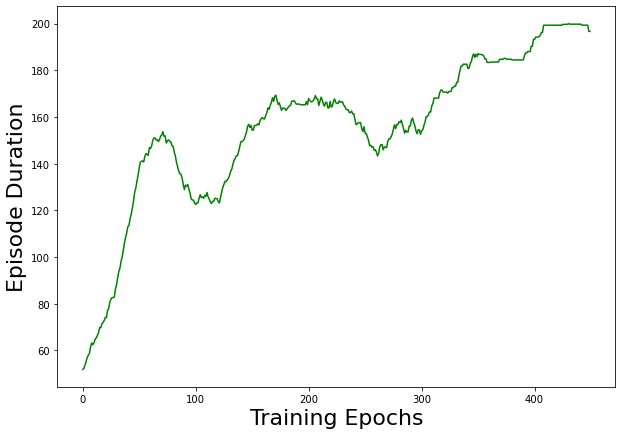

In [10]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

##### Listing 4.9

In [11]:
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1).float()) #G
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
        state2, reward, done, info = env.step(action) #I
        state1 = state2 
        t += 1
        if t > MAX_DUR: #L
            break;
    state1 = env.reset()
    done = False
    score.append(t)
score = np.array(score)

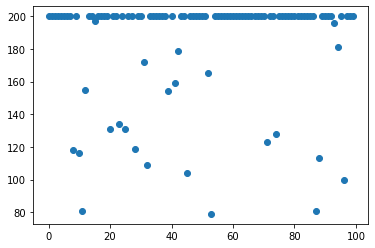

In [12]:
plt.scatter(np.arange(score.shape[0]),score)

REINFORCE는 정책함수를 효과적이고 쉽게 훈련  
그러나 state, action이 많아지면 각 에피소드에서 동작들을 모두 강화했을 때 좋은 동작만 강화되기 어려움  
더 정교한 방법, to be continue